In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import pylab as plt
import back_test_bot as bb

In [24]:
df = bb.fetch_btc_history(interval="1h", start_date="2024-01-01")

In [27]:
# Compute rolling VWAP
df["vwap"] = bb.rolling_vwap(df, window=12)

In [28]:
# Detect deviations > 3%
df = bb.detect_deviation(df, threshold=0.01)

In [29]:
df = bb.trade_direction(df)

In [30]:
df = bb.best_bot(df)

In [31]:
df_sample = df.tail(200)

In [32]:
def plot_trade_events(df):
    fig, ax = plt.subplots(figsize=(10,8))
    df.plot(ax=ax, x='timestamp',y='price')
    df.plot(ax=ax, x='timestamp',y='deviation',secondary_y=True,alpha=0.2,ls='-.')
    df.plot(ax=ax, x='timestamp',y='vwap',color='k',ls=':')
    df[df['direction']==1].plot.scatter(ax=ax, x='timestamp',y='price', color='green',label = 'buy')
    df[df['direction']==-1].plot.scatter(ax=ax, x='timestamp',y='price', color='red', label = "sell")
    ax.legend(ncols=5)

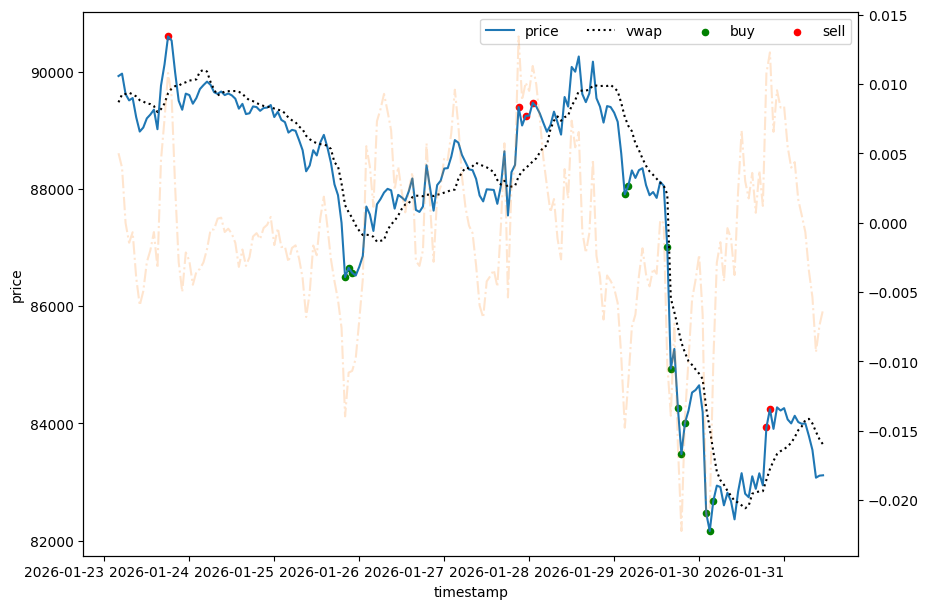

In [33]:
plot_trade_events(df_sample)

In [89]:
df['direction'].value_counts()

direction
 0    15285
-1     1600
 1     1390
Name: count, dtype: int64

#### Populate wallet

In [94]:
df = bb.update_wallet(df, wallet_value=100)

In [85]:
df = bb.trade_value(df, trade_volume='trade_volume',column_out="trade_value")

In [86]:
df = bb.trade_value(df, trade_volume='wallet_volume', column_out="wallet_value")

In [95]:
df_trades = df[df['signal']]

<Axes: xlabel='timestamp'>

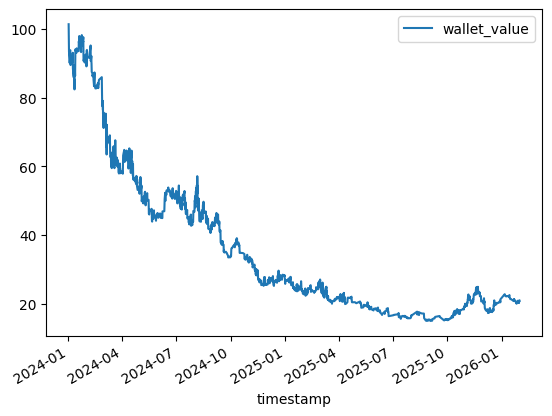

In [96]:
df_trades.plot(x='timestamp',y='wallet_value')

<Axes: >

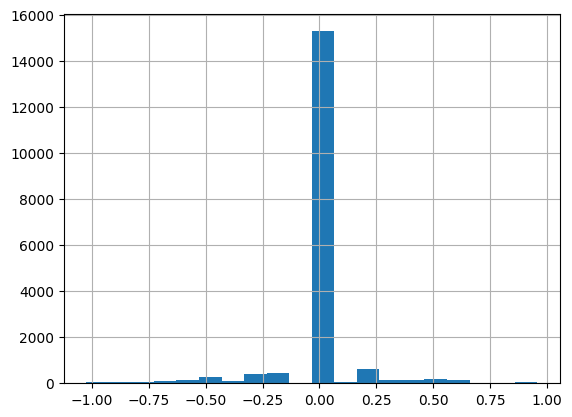

In [82]:
df['trade_value'].hist(bins=20)

In [45]:
bb.trade_volume(df,unit_price=inittial_price)

TypeError: cannot perform __mul__ with this index type: DatetimeArray

In [39]:
df.head(5)

,timestamp,high,low,price,volume,vwap,deviation,signal,direction,max_profit,wallet_value,wallet_volume
0,2024-01-01 00:59:59,42554.57,42261.02,42475.23,1271.68108,NaN,NaN,False,0,293.55,100.0,0.002354
1,2024-01-01 01:59:59,42775.00,42431.65,42613.56,1196.37856,NaN,NaN,False,0,343.35,NaN,NaN
2,2024-01-01 02:59:59,42638.41,42500.00,42581.10,685.21980,NaN,NaN,False,0,138.41,NaN,NaN
3,2024-01-01 03:59:59,42586.64,42230.08,42330.49,794.80391,NaN,NaN,False,0,356.56,NaN,NaN
4,2024-01-01 04:59:59,42399.99,42209.46,42399.99,715.41760,NaN,NaN,False,0,190.53,NaN,NaN


In [15]:
def plot_profit(df):
    cum_max = round(df['max_profit'].sum())
    df.plot(x='timestamp',y='max_profit', ylabel = 'Profit (USD)', title = f'Cumulative max: ${cum_max}')

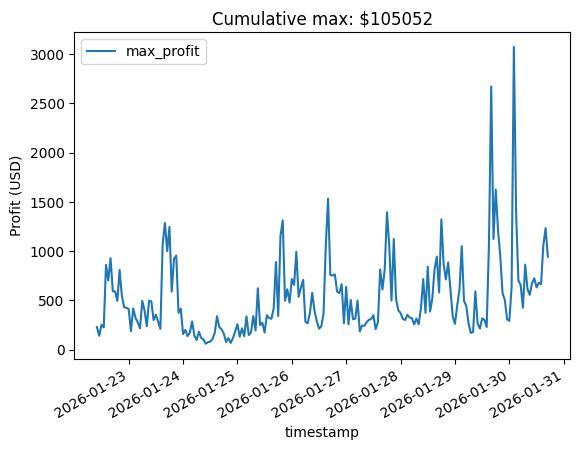

In [16]:
plot_profit(df_sample)

In [17]:
df['trade'].value_counts(normalize=True)

trade
Wait    0.836337
Sell    0.087528
Buy     0.076135
Name: proportion, dtype: float64

## Fourier transform

In [18]:
# 5. Fourier analysis
price_series = df.set_index("timestamp")["price"]
returns = bb.detrend_series(price_series, method="log_return")

In [19]:
# 14-day rolling FFT on hourly data
fft_window = 24*7
dominant_cycles = bb.dominant_cycle(
    returns,
    window=fft_window,
    sampling_interval=1.0
)

In [20]:
# Align output
cycle_df = pd.DataFrame({
    "timestamp": returns.index[fft_window:],
    "dominant_cycle_hours": dominant_cycles
})

(0.0, 5.0)

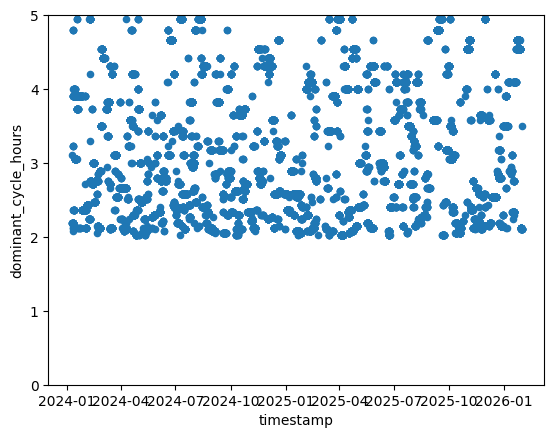

In [24]:
cycle_df.plot.scatter(x='timestamp',y='dominant_cycle_hours')
plt.ylim(0,5)

In [18]:
cycle_df.mean()

timestamp               2025-01-15 17:59:59.999000320+00:00
dominant_cycle_hours                               7.058169
dtype: object

In [19]:
cycle_df['dominant_cycle_hours'].value_counts()

dominant_cycle_hours
2.584615      475
4.097561      466
4.307692      440
8.842105      438
2.400000      424
             ... 
3.294118       71
2.947368       63
7.304348       59
10.500000      36
168.000000     27
Name: count, Length: 83, dtype: int64

In [20]:
import sys
sys.executable


'/opt/homebrew/Cellar/jupyterlab/4.4.6/libexec/bin/python'